In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import os
import pathlib

In [3]:
data_path = pathlib.Path("asl_alphabet_train")
data_path = os.path.join(data_path, os.listdir(data_path)[0])
print(data_path)

asl_alphabet_train\asl_alphabet_train


In [4]:
# data_path_test = pathlib.Path("asl_alphabet_test")
# data_path_test = os.path.join(data_path_test, os.listdir(data_path_test)[0])
# print(data_path_test)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    image_size = (256, 256),
    batch_size = 32
)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [6]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    image_size = (256, 256),
    batch_size = 32
)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [7]:
class_names = dataset.class_names

In [8]:
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

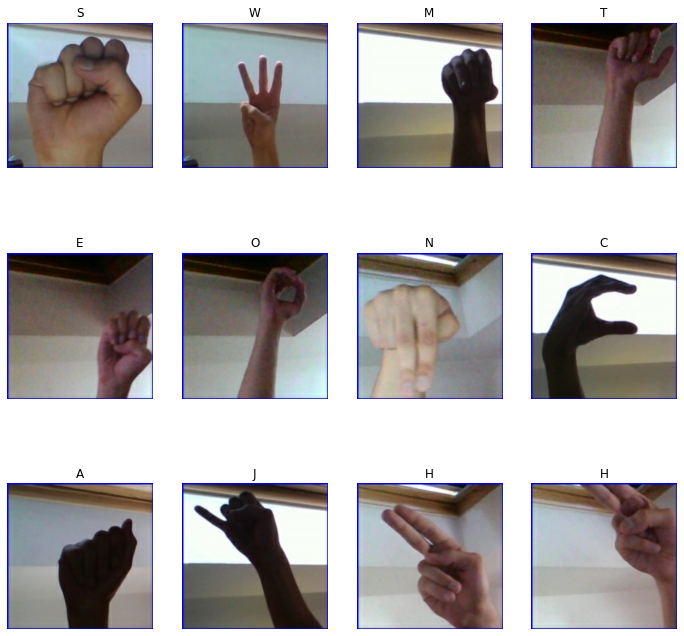

In [10]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [33]:
# def split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=50):
#     assert (train_split + test_split + val_split) == 1
    
#     ds_size = len(ds)
#     if shuffle:
#         ds.shuffle(shuffle_size, seed=123)
        
#     train_size = int(ds_size * train_split)
#     val_size = int(ds_size * val_split)
    
#     train_ds = ds.take(train_size)
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, test_ds, val_ds

In [34]:
# train_ds, test_ds, val_ds = split_data(dataset)


In [35]:
# train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Pré-processamento + mapped_function

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = dataset.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet")

vgg16.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.applications.vgg16.preprocess_input(
    inputs, data_format=None)

x = vgg16(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
outputs = tf.keras.layers.Dense(29, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
#modelling

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(29,activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [18]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [19]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [21]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [ ]:
history = model.fit(train_ds, epochs=3, validation_data=test)

In [46]:
model.evaluate(test)


38/38 [==============================] - 8s 207ms/step - loss: 0.6736 - accuracy: 0.5075


[0.6736366152763367, 0.5074999928474426]

In [ ]:
model.save('model_with_all_classes.h5')